In [1]:
# using Pkg
# Pkg.generate("model2")

In [2]:
# using Pkg
# Pkg.add("OrdinaryDiffEq")
# Pkg.add("DifferentialEquations")
# Pkg.add("ModelingToolkit")
# Pkg.add("DataDrivenDiffEq")
# Pkg.add("LinearAlgebra")
# Pkg.add("DiffEqSensitivity")
# Pkg.add("Optim")
# Pkg.add("DiffEqFlux")
# Pkg.add("Flux")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("GLM")
# Pkg.add("StatsModels")
# Pkg.add("CSV")
# Pkg.add("Interpolations")
# Pkg.add("JLD2")
# Pkg.add("Suppressor")
# Pkg.add("Distributed")
# Pkg.add("ParallelDataTransfer")
# Pkg.add("LaTeXStrings")
# Pkg.add("Statistics")
# Pkg.add("StatsBase")

In [3]:
println(@__DIR__)
using Pkg
# Pkg.update()
Pkg.activate(string(@__DIR__, "/model0/Project.toml"))
Pkg.status()
# Pkg.instantiate()

/home/ziyu/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload


 Activating environment at `~/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload/model0/Project.toml`


Project model0 v0.1.0
Status `~/solow/NODE/Neural Ordinary Differential Equations for the Regression and Prediction of Macroeconomics Data under the Green Solow Model/Upload/model0/Project.toml`
  [336ed68f] CSV v0.8.4
  [2445eb08] DataDrivenDiffEq v0.5.5
  [a93c6f00] DataFrames v0.22.5
  [aae7a2af] DiffEqFlux v1.23.0
  [41bf760c] DiffEqSensitivity v6.33.0
  [0c46a032] DifferentialEquations v6.16.0
  [587475ba] Flux v0.11.1
  [38e38edf] GLM v1.4.0
  [a98d9a8b] Interpolations v0.13.1
  [033835bb] JLD2 v0.4.2
  [b964fa9f] LaTeXStrings v1.2.1
  [961ee093] ModelingToolkit v5.11.0
  [429524aa] Optim v1.2.4
  [1dea7af3] OrdinaryDiffEq v5.51.1
  [2dcacdae] ParallelDataTransfer v0.5.0
  [91a5bcdd] Plots v1.6.12
  [2913bbd2] StatsBase v0.33.3
  [3eaba693] StatsModels v0.6.21
  [fd094767] Suppressor v0.2.0
  [9ff05d80] TickTock v1.1.0
  [8ba89e20] Distributed 
  [37e2e46d] LinearAlgebra 
  [10745b16] Statistics 


In [4]:
# # cd(@__DIR__)
# # using Pkg; Pkg.activate("."); Pkg.instantiate()
using OrdinaryDiffEq, DifferentialEquations
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
using DataFrames, GLM, StatsModels
using CSV
using Interpolations
using JLD2
using Suppressor
using Distributed
using ParallelDataTransfer
using LaTeXStrings, Statistics
using StatsBase
gr()

Plots.GRBackend()

# Cleaning the data and importing parameters

We import the weights and biases of the neural network for Botswana but these just represent a good initialisation point, whcih reduces time for training later on. 

In [5]:
file_dir2 = string(@__DIR__, "/model2_initialisation/")
country = "Botswana"
paras = CSV.read(string(file_dir2,country,"_model2paras.csv"),normalizenames = true, DataFrame)
# country = "United_States"
nnp = Array(paras[!, country])

412-element Array{Float64,1}:
 -0.4196754735746478
 -0.5836297970257099
 -0.031686016132200255
  0.387759999425736
  0.20409178899790764
  0.5584994619001119
  0.4105113868827661
 -0.47006830282429823
  0.4468151349435031
  0.38605400024478465
  0.4536616925879103
  0.21841410639816608
 -0.4126536039910048
  ⋮
  0.18138555985359803
 -0.30626097555209464
 -0.18905057338974102
  0.31111340369710805
 -0.2791555685167863
  0.125179726208638
  0.3009177535055671
  0.3625034851290459
 -0.01234057581925914
  0.009716218779777734
  0.01974084715853697
 -0.02563566341046498

In [6]:
function getCleandataFrame(country)
    df_year=df[!,"Year"][2:end]
    df1=df[!,string(country,"_yt")]  #GDP
    df2=df[!,string(country,"_kt")] #capital per capita
    df3=df[!,string(country,"_srate")][2:end] # savig rate
    df6= df[!,string(country,"_et")] #population
    df4= df[!,string(country,"_nt")][2:end] #population
    df8=df6[1:end-1] .-df6[2:end]#de
    df6=df6[2:end]
    df5=df2[1:end-1] .-df2[2:end] #dk
    df2=df2[2:end]
    df7= df1[1:end-1] .-df1[2:end] # dydt
    df1=df1[2:end]
    newdf= DataFrame(Year=df_year,yt=df1, k=df2, srate=df3,nt=df4,dkdt=df5,dydt=df7,dedt=df8,et=df6)
    newdf=newdf[completecases(newdf), :]
    return newdf, df8, df5, df7
end

getCleandataFrame (generic function with 1 method)

In [7]:
df = CSV.read(string(@__DIR__, "/compileddf.csv"),
    normalizenames = true, 
    DataFrame)

,Year,Albania_et,Albania_yt,Albania_Popt,Albania_nt,Albania_Ktotal,Albania_kt
,Int64,Float64?,Float64?,Float64,Float64?,Float64?,Float64?
1,1959,missing,missing,1.57133e6,missing,missing,missing
2,1960,1.25819,0.001451,1.62311e6,0.0329562,missing,missing
3,1961,1.37419,0.001463,1.67664e6,0.0329743,missing,missing
4,1962,1.43996,0.001511,1.72814e6,0.0307175,missing,missing
5,1963,1.18168,0.001563,1.77972e6,0.029846,missing,missing
6,1964,1.11174,0.001616,1.83228e6,0.0295379,missing,missing
7,1965,1.1661,0.001675,1.88365e6,0.028035,missing,missing
8,1966,1.33306,0.001738,1.93296e6,0.0261784,missing,missing
9,1967,1.36375,0.001804,1.98406e6,0.0264345,missing,missing


In [8]:
newdf, df8, df5, df7=getCleandataFrame(country)
years_available=size(newdf)[1]


st = interpolate(newdf[!,"srate"], BSpline(Quadratic(Free(OnCell()))))
nt = interpolate(newdf[!,"nt"], BSpline(Quadratic(Free(OnCell()))))

kdata= newdf[!,"k"]
ydata=newdf[!,"yt"]
edata=newdf[!,"et"]
kic= newdf[!,"k"][1]
yic=newdf[!,"yt"][1]
eic=newdf[!,"et"][1]

newdf

,Year,yt,k,srate,nt,dkdt,dydt,dedt
,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,1975,0.001223,0.00408493,0.202551,0.0488591,-0.000141476,7.7e-5,-0.129126
2,1976,0.001381,0.00404858,0.216694,0.0520614,3.63524e-5,-0.000158,-0.519256
3,1977,0.001358,0.00402169,0.222357,0.0542297,2.68853e-5,2.3e-5,-0.204174
4,1978,0.001537,0.00407305,0.227837,0.0521772,-5.13577e-5,-0.000179,-0.0242368
5,1979,0.001613,0.00424262,0.298039,0.0490789,-0.00016957,-7.6e-5,-0.0894769
6,1980,0.001765,0.00457454,0.286999,0.0439067,-0.000331921,-0.000152,-0.00922081
7,1981,0.001858,0.00477105,0.278738,0.0377156,-0.000196508,-9.3e-5,0.0147756
8,1982,0.001921,0.00494978,0.266413,0.0387538,-0.000178735,-6.3e-5,-0.0586634
9,1983,0.002144,0.00482787,0.29919,0.0374656,0.000121908,-0.000223,0.108086


# Initialising the neural network

In [9]:
ann = FastChain(FastDense(3, 12, tanh),FastDense(12, 12, tanh),FastDense(12, 12, tanh),
                FastDense(12, 4))

(::FastChain{Tuple{FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(tanh),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}},FastDense{typeof(identity),DiffEqFlux.var"#initial_params#130"{typeof(Flux.glorot_uniform),typeof(Flux.zeros),Int64,Int64}}}}) (generic function with 1 method)

# Optimising the neural network

In [10]:
function solownneqn1(du,u,p,t)
    sₜ = st(t) #savings rate
    nₜ = nt(t)

    k = u[1]
    y=u[2]
    e=u[3]
    α,δ,gᵦ,gₐ= ann([k,y,e],p)
    du[1] = sₜ*y-(δ+nₜ+gᵦ)*k # rate of change of kt
    du[2] = y*(gᵦ+α*du[1]/k) # rate of change of yt
    du[3] = e*(-gₐ+du[2]/y)
    return du
end

nntspan = (1.0e0,years_available*1.0) ## the year is hard coded, to be changed later
nndatasize = years_available
nntsteps = range(nntspan[1], nntspan[2], length=nndatasize)
u0 = Float32[kic,yic,eic] ## kt initial
prob_solownneqn = ODEProblem(solownneqn1, u0, nntspan, nnp)
pred = solve(prob_solownneqn, TRBDF2(),p=nnp, abstol=1e-4, reltol=1e-4, saveat = nntsteps)

function predicts(θ)
    Array(solve(prob_solownneqn,TRBDF2(),p=θ, abstol=1e-4, reltol=1e-4, saveat = nntsteps))
end

losses=[]

    
function loss(θ)
    pred = predicts(θ)
    kloss=sum(abs,(pred[1,:].-kdata))./ sum(pred[1,:].+ kdata)
    yloss=sum(abs, (pred[2,:].-ydata))./sum(pred[2,:].+ydata)
    eloss=sum(abs,(pred[3,:].-edata))./sum(pred[3,:].+edata)
    return ((kloss+eloss+yloss)), pred
end
          
        
# show(loss(nnp))
callback(θ,l,pred) = begin
        push!(losses, l)
#         display(plot(losses, yaxis=:log))
#         if length(losses)%99==0 #print every 50 steps
#             println(losses[end])

#         end
        false
end


callback (generic function with 1 method)

In [11]:
res1= DiffEqFlux.sciml_train(loss, nnp, ADAM(0.0001),cb=callback, maxiters=100)

while ((mean(losses[end-100:end-50])>=(1.001*mean(losses[end-49:end]))) || std(losses[end-49:end]) >=0.001) && length(losses) <3000

res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.0001),cb=callback, maxiters=200)
try
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)

catch e
    print("Problematics")
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.0001),cb=callback, maxiters=100)
end
res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.00001),cb=callback, maxiters=100)
try
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.000001/100),cb=callback, maxiters=100)
catch e
    res1= DiffEqFlux.sciml_train(loss, res1.minimizer, ADAM(0.00001),cb=callback, maxiters=100)
    print("Problematics")
end

end
pred = solve(prob_solownneqn, TRBDF2(),p=res1.minimizer, abstol=1e-4, reltol=1e-4, saveat = nntsteps)

# kmse = Flux.mse(pred[1,:],kdata)
# ymse = Flux.mse(pred[2,:],ydata)
# emse = Flux.mse(pred[3,:],edata)
# println(kmse,"",ymse,"",emse)

loss: 0.121: 100%|██████████████████████████████████████| Time: 0:01:12
loss: 0.117: 100%|██████████████████████████████████████| Time: 0:02:13
loss: 0.116: 100%|██████████████████████████████████████| Time: 0:00:41
loss: 0.115: 100%|██████████████████████████████████████| Time: 0:01:32
loss: 0.114: 100%|██████████████████████████████████████| Time: 0:00:47
loss: 0.114: 100%|██████████████████████████████████████| Time: 0:01:28
loss: 0.113: 100%|██████████████████████████████████████| Time: 0:00:44
loss: 0.112: 100%|██████████████████████████████████████| Time: 0:01:24
loss: 0.112: 100%|██████████████████████████████████████| Time: 0:00:42
loss: 0.111: 100%|██████████████████████████████████████| Time: 0:01:19
loss: 0.111: 100%|██████████████████████████████████████| Time: 0:00:43


retcode: Success
Interpolation: 1st order linear
t: 34-element Array{Float64,1}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
 11.0
 12.0
 13.0
  ⋮
 23.0
 24.0
 25.0
 26.0
 27.0
 28.0
 29.0
 30.0
 31.0
 32.0
 33.0
 34.0
u: 34-element Array{Array{Float32,1},1}:
 [0.0040849275, 0.001223, 0.25226375]
 [0.0037468649, 0.0013287815, 0.31691095]
 [0.0034856587, 0.0014432039, 0.3942509]
 [0.0032975096, 0.0015655389, 0.4844154]
 [0.0032451965, 0.0016867537, 0.58389395]
 [0.0033006517, 0.0018053274, 0.69019836]
 [0.0033937332, 0.0019269893, 0.80304015]
 [0.003526509, 0.002050173, 0.9190346]
 [0.003711051, 0.0021718682, 1.0341096]
 [0.003937184, 0.0022933658, 1.1474572]
 [0.0042747967, 0.0024012867, 1.2501422]
 [0.0047885096, 0.0024852287, 1.3358045]
 [0.0054163947, 0.0025600255, 1.4117794]
 ⋮
 [0.013642114, 0.003649332, 2.0825238]
 [0.014908051, 0.0037668673, 2.1232255]
 [0.016353637, 0.003879019, 2.1574335]
 [0.017981559, 0.0039875438, 2.1868327]
 [0.019823836, 0.004091025, 2.211

In [12]:
for i in 1:34
    println(ann([kdata[i], ydata[i], edata[i]], res1.minimizer))
end


[-0.1545214806258775, 0.03639410013141744, 0.06860040531410191, -0.14933624422914055]
[-0.25816213532358095, 0.015762485034083926, 0.07224419654159317, -0.08346752590730054]
[-0.2921499576605768, 0.004523351213454572, 0.0727287223692413, -0.061011615365288464]
[-0.2959850586992045, 0.0029920180600680364, 0.0727120809536613, -0.05858727756928371]
[-0.3094614790317624, -0.002717954889978152, 0.0727550850288205, -0.04980943206078586]
[-0.3108733962158681, -0.0036063988918800353, 0.07261190593951306, -0.04906447417768086]
[-0.3087595142552837, -0.0028423133871785487, 0.0725026721608471, -0.05056163115309376]
[-0.31723174606669896, -0.006782508179166171, 0.07248872819363661, -0.04509576660651382]
[-0.30150626743038644, 0.00014901939104324316, 0.0723586020066698, -0.05549657861029792]
[-0.29834011668165916, 0.0013892429291325094, 0.07228309540711808, -0.057674609941772974]
[-0.30888014885704007, -0.0030614128923639704, 0.07232957528923475, -0.05079912899879991]
[-0.2902295664177996, 0.004224

# Plotting a graph

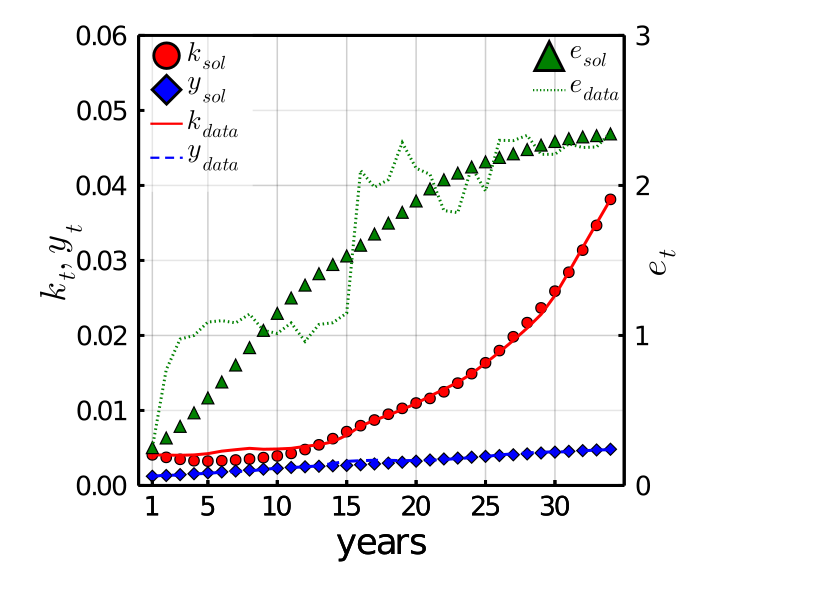

In [13]:
 function plot_graph(nnpred,country,nntstepsfull,kdata,ydata,edata)
    upscale = 0.5 #1 #8x upscaling in resolution
    fntsm = Plots.font("sans-serif", pointsize=round(12.0*upscale))
    fntlg = Plots.font("sans-serif", pointsize=round(16.0*upscale))
    default(titlefont=fntlg, guidefont=fntlg, tickfont=fntsm, legendfont=fntsm)
    default(size=(550*upscale,400*upscale)) #Plot canvas size
    default(dpi=300)
    
    plotkyenn12ic= Plots.scatter(xaxis=nntstepsfull,nnpred[1:2,:]',
        label=[L"k_{sol}" L"y_{sol}"],color=[:red :blue],legend=(0.102,0.955),
        markershape=[:circle :diamond],markersize=4*upscale,
        ylabel=L"k_t,y_t",right_margin = 15Plots.mm)
            
    plot!(plotkyenn12ic,[kdata,ydata],label=[L"k_{data}" L"y_{data}"],linestyle=[:solid :dash],
        color=[:red :blue],ylim=(0,1.5.*round(maximum(kdata);sigdigits=1)),foreground_color_legend = nothing)


    pr = twinx()

    Plots.scatter!(pr,nntstepsfull,nnpred[3,:],
        label=L"e_{sol}",color=:green,legend=(0.89,0.954), markershape = [:utriangle], markersize=4*upscale,
        ylabel=L"e_t",right_margin = 15Plots.mm,
        foreground_color_legend = nothing,background_color_legend = nothing)
            
    plot!(pr,edata,label=L"e_{data}",color=:green,ylim=(0,1.5.*round(maximum(edata);sigdigits=1)),
                linestyle=:dot)
    
 xpts = collect(0:5:5*ceil(length(nntstepsfull)/5))

        xpts[1]=1

    
   plot(plotkyenn12ic,xlabel = "years",xticks=xpts,box=:on,linewidth=2*upscale)

#     savefig(string(country,"model5_190621"))
end

plot_graph(pred,country,nntsteps,kdata,ydata,edata)

# Calculating errors

In [14]:
Botswana_k_pred = convert(Array{Float64},pred[1,:])
Botswana_y_pred = convert(Array{Float64},pred[2,:])
Botswana_e_pred = convert(Array{Float64},pred[3,:])

kdata = identity.(kdata)
ydata = identity.(ydata)
edata = identity.(edata)

#checking the implementation of MSE
# println("(Botswana Mean Squared Errors) kt: ", Flux.mse(Botswana_k_pred, kdata), 
#     " yt: ", Flux.mse(Botswana_y_pred, ydata), 
#     " et: ", Flux.mse(Botswana_e_pred, edata))
println("(Botswana Mean Squared Errors) kt: ", (sqL2dist(Botswana_k_pred, kdata)/length(kdata)), 
    " yt: ", (sqL2dist(Botswana_y_pred, ydata)/length(ydata)), 
    " et: ", (sqL2dist(Botswana_e_pred, edata)/length(edata)))
println("(Botswana Root Mean Squared Errors) kt: ", (L2dist(Botswana_k_pred, kdata)/length(kdata)), 
    " yt: ", (L2dist(Botswana_y_pred, ydata)/length(ydata)), 
    " et: ", (L2dist(Botswana_e_pred, edata)/length(edata)))
#checking the implementation of MAE
# println("(Botswana Mean Absolute Errors) kt: ", Flux.mae(Botswana_k_pred, kdata), 
#     " yt: ", Flux.mae(Botswana_y_pred, ydata), 
#     " et: ", Flux.mae(Botswana_e_pred, edata))
println("(Botswana Mean Absolute Errors) kt: ", 
    L1dist(convert(Array{Float64},Botswana_k_pred),kdata)/length(kdata), 
    " yt: ", L1dist(convert(Array{Float64},Botswana_y_pred),ydata)/length(ydata), 
    " et: ", L1dist(convert(Array{Float64},Botswana_e_pred),edata)/length(edata))


function r2_impl(data,pred)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
return r2  
end
#checking the implementation of R2
# println("(Botswana R2 Correlation Coefficient) yt: ", r2(ols_y_Botswana),
#     " et: ", r2(ols_e_Botswana))
# println("(Botswana R2 Correlation Coefficient) yt: ", r2_impl(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana)),
#     " et: ", r2_impl(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana)))
println("(Botswana R2 Correlation Coefficient) kt: ", r2_impl(kdata, Botswana_k_pred), 
    " yt: ", r2_impl(ydata, Botswana_y_pred), 
    " et: ", r2_impl(edata, Botswana_e_pred))

function Ar2_impl(data,pred, p)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
n = size(data)[1]
# ar2 = 1 - (1 - r2)*(n-1)/(n-p-1)
ar2 = 1 - (1 - r2)*(n-1)/(n-p) 
# using this formula means that the intercept is also counted as a parameter
# this formula requires we be explicit about all parameters
return ar2  
end

#checking the implementation of adjusted R2
# println("(Botswana Adjusted R2) yt: ", adjr2(ols_y_Botswana),
#     " et: ", adjr2(ols_e_Botswana))
# println("(Botswana Adjusted R2) yt: ", Ar2_impl(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),2),
#     " et: ", Ar2_impl(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),2))
# for regular regression:
# 3 parameters are coeff of lge, coeff of t, y intercept 
# for k, there are 5 parameters including intercept
# for neural network, there are 412 parameters 
# (should divide by 3 because 412 parameters are used for 3 equations?)
println("(Botswana Adjusted R2) kt: ", Ar2_impl(kdata, Botswana_k_pred, 412), 
    " yt: ", Ar2_impl(ydata, Botswana_y_pred, 412), 
    " et: ", Ar2_impl(edata, Botswana_e_pred, 412))

println("(Botswana Mean Percentage Error) kt: ", mean((kdata.- Botswana_k_pred)./kdata)*100,
    " yt: ", mean((ydata.- Botswana_y_pred)./ydata)*100,
    " et: ", mean((edata.- Botswana_e_pred)./edata)*100)

println("(Botswana Mean Absolute Percentage Error) kt: ", mean(abs.((kdata.- Botswana_k_pred)./kdata))*100,
    " yt: ", mean(abs.((ydata.- Botswana_y_pred)./ydata))*100,
    " et: ", mean(abs.((edata.- Botswana_e_pred)./edata))*100)

println("(Botswana Mean Arctangent Absolute Percentage Error) kt: ", mean(atan.(abs.((kdata.- Botswana_k_pred)./kdata)))*100,
    " yt: ", mean(atan.(abs.((ydata.- Botswana_y_pred)./ydata)))*100,
    " et: ", mean(atan.(abs.((edata.- Botswana_e_pred)./edata)))*100)

println("(Botswana Mean Bias Error) kt: ", mean(kdata.- Botswana_k_pred),
    " yt: ", mean(ydata.- Botswana_y_pred),
    " et: ", mean(edata.- Botswana_e_pred))

function loglikelihood_calc(data,pred)
rss = sum((data .-pred).^2)
n = length(pred)
return -n/2*(log(2pi*rss/n)+1)
end
# implementation from julia: https://github.com/JuliaStats/GLM.jl/blob/950579166c52ff1cbbeab75cbc23235b30640802/src/lm.jl

#checking implementation for loglikelihood
# println("(Botswana Loglikelihood) yt: ", loglikelihood(ols_y_Botswana),
#     " et: ", loglikelihood(ols_e_Botswana))
# println("(Botswana Loglikelihood) yt: ", loglikelihood_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana)),
#     " et: ", loglikelihood_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana)))
println("(Botswana Loglikelihood) kt: ", loglikelihood_calc(kdata, Botswana_k_pred),
    " yt: ", loglikelihood_calc(ydata, Botswana_y_pred),
    " et: ", loglikelihood_calc(edata, Botswana_e_pred))

function aic_calc(data, pred, params)
    L = loglikelihood_calc(data,pred)
    return 2*params-2*L
end

#checking implementation for aic
# println("(Botswana Aikaike Information Criterion) yt: ", aic(ols_y_Botswana),
#     " et: ", aic(ols_e_Botswana))
# println("(Botswana Aikaike Information Criterion) yt: ", aic_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", aic_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana Aikaike Information Criterion) kt: ", aic_calc(kdata, Botswana_k_pred, 412),
    " yt: ", aic_calc(ydata, Botswana_y_pred, 412),
    " et: ", aic_calc(edata, Botswana_e_pred, 412))

function aicc_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + 2*params + 2*params*(params+1)/(n-params-1)
end

# checking implementation for aicc
# println("(Botswana Corrected AIC) yt: ", aicc(ols_y_Botswana),
#     " et: ", aicc(ols_e_Botswana))
# println("(Botswana Corrected AIC) yt: ", aicc_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", aicc_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana Corrected AIC) kt: ", aicc_calc(kdata, Botswana_k_pred, 412),
    " yt: ", aicc_calc(ydata, Botswana_y_pred, 412),
    " et: ", aicc_calc(edata, Botswana_e_pred, 412))

function bic_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + params*log(n)
end

# checking implementation for bic_calc
# println("(Botswana Corrected BIC) yt: ", bic(ols_y_Botswana),
#     " et: ", bic(ols_e_Botswana))
# println("(Botswana Corrected BIC) yt: ", bic_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", bic_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana BIC) kt: ", bic_calc(kdata, Botswana_k_pred, 412),
    " yt: ", bic_calc(ydata, Botswana_y_pred, 412),
    " et: ", bic_calc(edata, Botswana_e_pred, 412))

println("(param-adj)(Botswana Adjusted R2) kt: ", Ar2_impl(kdata, Botswana_k_pred, 386), 
    " yt: ", Ar2_impl(ydata, Botswana_y_pred, 386), 
    " et: ", Ar2_impl(edata, Botswana_e_pred, 373))
println("(param-adj)(Botswana Aikaike Information Criterion) kt: ", aic_calc(kdata, Botswana_k_pred, 386),
    " yt: ", aic_calc(ydata, Botswana_y_pred, 386),
    " et: ", aic_calc(edata, Botswana_e_pred, 373))
println("(param-adj)(Botswana Corrected AIC) kt: ", aicc_calc(kdata, Botswana_k_pred, 386),
    " yt: ", aicc_calc(ydata, Botswana_y_pred, 386),
    " et: ", aicc_calc(edata, Botswana_e_pred, 373))
println("(param-adj)(Botswana BIC) kt: ", bic_calc(kdata, Botswana_k_pred, 386),
    " yt: ", bic_calc(ydata, Botswana_y_pred, 386),
    " et: ", bic_calc(edata, Botswana_e_pred, 373))

(Botswana Mean Squared Errors) kt: 3.823393096038759e-7 yt: 3.6876252238859095e-8 et: 0.08421853922945764
(Botswana Root Mean Squared Errors) kt: 0.0001060437353730936 yt: 3.2933199876174976e-5 et: 0.04976962788377999
(Botswana Mean Absolute Errors) kt: 0.00045454319231810655 yt: 0.0001200025793822373 et: 0.2332938676635191
(Botswana R2 Correlation Coefficient) kt: 0.9958952380251704 yt: 0.9688904079672931 et: 0.7705416616643807
(Botswana Adjusted R2) kt: 1.0003583522358979 yt: 1.0027159167647601 et: 1.0200320771562843
(Botswana Mean Percentage Error) kt: 5.559473776302629 yt: 1.736042785076783 et: 5.372717306008116
(Botswana Mean Absolute Percentage Error) kt: 7.440108643682894 yt: 3.975802738085614 et: 18.230772411667015
(Botswana Mean Arctangent Absolute Percentage Error) kt: 7.331320428997623 yt: 3.959989102321276 et: 17.420477341414617
(Botswana Mean Bias Error) kt: 0.00020785846223220447 yt: 6.769660210960052e-5 et: 0.06989052897245385
(Botswana Loglikelihood) kt: 202.96436528955

In [15]:
kdata = identity.(kdata[2:end-1].-kdata[1:end-2])
Botswana_k_pred = Botswana_k_pred[2:end-1].-Botswana_k_pred[1:end-2]
Botswana_y_pred = Botswana_y_pred[2:end-1].-Botswana_y_pred[1:end-2]
ydata = identity.(ydata[2:end-1].-ydata[1:end-2])
Botswana_e_pred = Botswana_e_pred[2:end-1].-Botswana_e_pred[1:end-2]
edata = identity.(edata[2:end-1].-edata[1:end-2])

#checking the implementation of MSE
# println("(Botswana Mean Squared Errors) kt: ", Flux.mse(Botswana_k_pred, kdata), 
#     " yt: ", Flux.mse(Botswana_y_pred, ydata), 
#     " et: ", Flux.mse(Botswana_e_pred, edata))
println("(Botswana Mean Squared Errors) kt: ", (sqL2dist(Botswana_k_pred, kdata)/length(kdata)), 
    " yt: ", (sqL2dist(Botswana_y_pred, ydata)/length(ydata)), 
    " et: ", (sqL2dist(Botswana_e_pred, edata)/length(edata)))
println("(Botswana Root Mean Squared Errors) kt: ", (L2dist(Botswana_k_pred, kdata)/length(kdata)), 
    " yt: ", (L2dist(Botswana_y_pred, ydata)/length(ydata)), 
    " et: ", (L2dist(Botswana_e_pred, edata)/length(edata)))
#checking the implementation of MAE
# println("(Botswana Mean Absolute Errors) kt: ", Flux.mae(Botswana_k_pred, kdata), 
#     " yt: ", Flux.mae(Botswana_y_pred, ydata), 
#     " et: ", Flux.mae(Botswana_e_pred, edata))
println("(Botswana Mean Absolute Errors) kt: ", 
    L1dist(convert(Array{Float64},Botswana_k_pred),kdata)/length(kdata), 
    " yt: ", L1dist(convert(Array{Float64},Botswana_y_pred),ydata)/length(ydata), 
    " et: ", L1dist(convert(Array{Float64},Botswana_e_pred),edata)/length(edata))


function r2_impl(data,pred)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
return r2  
end
#checking the implementation of R2
# println("(Botswana R2 Correlation Coefficient) yt: ", r2(ols_y_Botswana),
#     " et: ", r2(ols_e_Botswana))
# println("(Botswana R2 Correlation Coefficient) yt: ", r2_impl(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana)),
#     " et: ", r2_impl(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana)))
println("(Botswana R2 Correlation Coefficient) kt: ", r2_impl(kdata, Botswana_k_pred), 
    " yt: ", r2_impl(ydata, Botswana_y_pred), 
    " et: ", r2_impl(edata, Botswana_e_pred))

function Ar2_impl(data,pred, p)
tss = sum((data .-mean(data)).^2)
rss = sum((data .-pred).^2)
r2 = 1- rss/tss
n = size(data)[1]
# ar2 = 1 - (1 - r2)*(n-1)/(n-p-1)
ar2 = 1 - (1 - r2)*(n-1)/(n-p) 
# using this formula means that the intercept is also counted as a parameter
# this formula requires we be explicit about all parameters
return ar2  
end

#checking the implementation of adjusted R2
# println("(Botswana Adjusted R2) yt: ", adjr2(ols_y_Botswana),
#     " et: ", adjr2(ols_e_Botswana))
# println("(Botswana Adjusted R2) yt: ", Ar2_impl(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),2),
#     " et: ", Ar2_impl(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),2))
# for regular regression:
# 3 parameters are coeff of lge, coeff of t, y intercept 
# for k, there are 5 parameters including intercept
# for neural network, there are 412 parameters 
# (should divide by 3 because 412 parameters are used for 3 equations?)
println("(Botswana Adjusted R2) kt: ", Ar2_impl(kdata, Botswana_k_pred, 412), 
    " yt: ", Ar2_impl(ydata, Botswana_y_pred, 412), 
    " et: ", Ar2_impl(edata, Botswana_e_pred, 412))

println("(Botswana Mean Percentage Error) kt: ", mean((kdata.- Botswana_k_pred)./kdata)*100,
    " yt: ", mean((ydata.- Botswana_y_pred)./ydata)*100,
    " et: ", mean((edata.- Botswana_e_pred)./edata)*100)

println("(Botswana Mean Absolute Percentage Error) kt: ", mean(abs.((kdata.- Botswana_k_pred)./kdata))*100,
    " yt: ", mean(abs.((ydata.- Botswana_y_pred)./ydata))*100,
    " et: ", mean(abs.((edata.- Botswana_e_pred)./edata))*100)

println("(Botswana Mean Arctangent Absolute Percentage Error) kt: ", mean(atan.(abs.((kdata.- Botswana_k_pred)./kdata)))*100,
    " yt: ", mean(atan.(abs.((ydata.- Botswana_y_pred)./ydata)))*100,
    " et: ", mean(atan.(abs.((edata.- Botswana_e_pred)./edata)))*100)

println("(Botswana Mean Bias Error) kt: ", mean(kdata.- Botswana_k_pred),
    " yt: ", mean(ydata.- Botswana_y_pred),
    " et: ", mean(edata.- Botswana_e_pred))

function loglikelihood_calc(data,pred)
rss = sum((data .-pred).^2)
n = length(pred)
return -n/2*(log(2pi*rss/n)+1)
end
# implementation from julia: https://github.com/JuliaStats/GLM.jl/blob/950579166c52ff1cbbeab75cbc23235b30640802/src/lm.jl

#checking implementation for loglikelihood
# println("(Botswana Loglikelihood) yt: ", loglikelihood(ols_y_Botswana),
#     " et: ", loglikelihood(ols_e_Botswana))
# println("(Botswana Loglikelihood) yt: ", loglikelihood_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana)),
#     " et: ", loglikelihood_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana)))
println("(Botswana Loglikelihood) kt: ", loglikelihood_calc(kdata, Botswana_k_pred),
    " yt: ", loglikelihood_calc(ydata, Botswana_y_pred),
    " et: ", loglikelihood_calc(edata, Botswana_e_pred))

function aic_calc(data, pred, params)
    L = loglikelihood_calc(data,pred)
    return 2*params-2*L
end

#checking implementation for aic
# println("(Botswana Aikaike Information Criterion) yt: ", aic(ols_y_Botswana),
#     " et: ", aic(ols_e_Botswana))
# println("(Botswana Aikaike Information Criterion) yt: ", aic_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", aic_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana Aikaike Information Criterion) kt: ", aic_calc(kdata, Botswana_k_pred, 412),
    " yt: ", aic_calc(ydata, Botswana_y_pred, 412),
    " et: ", aic_calc(edata, Botswana_e_pred, 412))

function aicc_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + 2*params + 2*params*(params+1)/(n-params-1)
end

# checking implementation for aicc
# println("(Botswana Corrected AIC) yt: ", aicc(ols_y_Botswana),
#     " et: ", aicc(ols_e_Botswana))
# println("(Botswana Corrected AIC) yt: ", aicc_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", aicc_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana Corrected AIC) kt: ", aicc_calc(kdata, Botswana_k_pred, 412),
    " yt: ", aicc_calc(ydata, Botswana_y_pred, 412),
    " et: ", aicc_calc(edata, Botswana_e_pred, 412))

function bic_calc(data, pred, params)
    n = length(pred)
    L = loglikelihood_calc(data,pred)
    return -2*L + params*log(n)
end

# checking implementation for bic_calc
# println("(Botswana Corrected BIC) yt: ", bic(ols_y_Botswana),
#     " et: ", bic(ols_e_Botswana))
# println("(Botswana Corrected BIC) yt: ", bic_calc(Botswana_y_reg[!, :lgyty0], predict(ols_y_Botswana),4),
#     " et: ", bic_calc(Botswana_e_reg[!, :lgete0], predict(ols_e_Botswana),4))
# 4 degrees of freedom in the model: intercept, two coefficients and variance

println("(Botswana BIC) kt: ", bic_calc(kdata, Botswana_k_pred, 412),
    " yt: ", bic_calc(ydata, Botswana_y_pred, 412),
    " et: ", bic_calc(edata, Botswana_e_pred, 412))

println("(param-adj)(Botswana Adjusted R2) kt: ", Ar2_impl(kdata, Botswana_k_pred, 386), 
    " yt: ", Ar2_impl(ydata, Botswana_y_pred, 386), 
    " et: ", Ar2_impl(edata, Botswana_e_pred, 373))
println("(param-adj)(Botswana Aikaike Information Criterion) kt: ", aic_calc(kdata, Botswana_k_pred, 386),
    " yt: ", aic_calc(ydata, Botswana_y_pred, 386),
    " et: ", aic_calc(edata, Botswana_e_pred, 373))
println("(param-adj)(Botswana Corrected AIC) kt: ", aicc_calc(kdata, Botswana_k_pred, 386),
    " yt: ", aicc_calc(ydata, Botswana_y_pred, 386),
    " et: ", aicc_calc(edata, Botswana_e_pred, 373))
println("(param-adj)(Botswana BIC) kt: ", bic_calc(kdata, Botswana_k_pred, 386),
    " yt: ", bic_calc(ydata, Botswana_y_pred, 386),
    " et: ", bic_calc(edata, Botswana_e_pred, 373))

(Botswana Mean Squared Errors) kt: 6.597334615104656e-8 yt: 8.728549399417725e-9 et: 0.05043339835784439
(Botswana Root Mean Squared Errors) kt: 4.5405584097335484e-5 yt: 1.651566434424616e-5 et: 0.0396994168557
(Botswana Mean Absolute Errors) kt: 0.00021476182143663152 yt: 6.958613355411222e-5 et: 0.14659788124639556
(Botswana R2 Correlation Coefficient) kt: 0.9273262547052672 yt: -0.33555974350474815 et: -0.026943155150429998
(Botswana Adjusted R2) kt: 1.0059286476424651 yt: 1.1089535580227559 et: 1.0837769416043772
(Botswana Mean Percentage Error) kt: -60.27880615232386 yt: 91.45637771777851 et: -18.58822956685022
(Botswana Mean Absolute Percentage Error) kt: 131.5693946812541 yt: 216.7855574536632 et: 382.2639680221305
(Botswana Mean Arctangent Absolute Percentage Error) kt: 48.55045392440139 yt: 54.830571153115784 et: 88.81279737281065
(Botswana Mean Bias Error) kt: 8.44947095950623e-6 yt: -1.7905133077873156e-7 et: -0.0023693058911614384
(Botswana Loglikelihood) kt: 219.138207300